# Financial Fraud Detection

With the rise of digital financing fraud, there is a need to be able to be able to better identify fraudulent transactions. The goal of this analysis is to better understand the dataset we have, preprocess it and create models for predictions.

**General Steps:**
- **Step 1**: Load prerequisites and required modules
- **Step 2**: Import dataset
- **Step 3**: Perform exploratory data analysis
- **Step 4**: Preprocess data for predictive modelling
- **Step 5**: Analyse the models obtained and decide on the best one

### Prerequisites

Let's first load the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install xgboost
!pip install imbalanced-learn

### Importing the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
df = pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Feature Descriptions:

**step**: Maps a unit of time in the real world. In this case 1 step is 1 hour of time.

**type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER

**amount**: amount of the transaction in local currency

**nameOrig**: customer who started the transaction

**oldbalanceOrg**: initial balance before the transaction

**newbalanceOrig**: customer's balance after the transaction.

**nameDest**: recipient ID of the transaction.

**oldbalanceDest**: initial recipient balance before the transaction.

**newbalanceDest**: recipient's balance after the transaction.

**isFraud**: identifies a fraudulent transaction (1) and non fraudulent (0)

**isFlaggedFraud**: flags illegal attempts to transfer more than 200.000 in a single transaction.

[0, 2, -1500000, 200000]

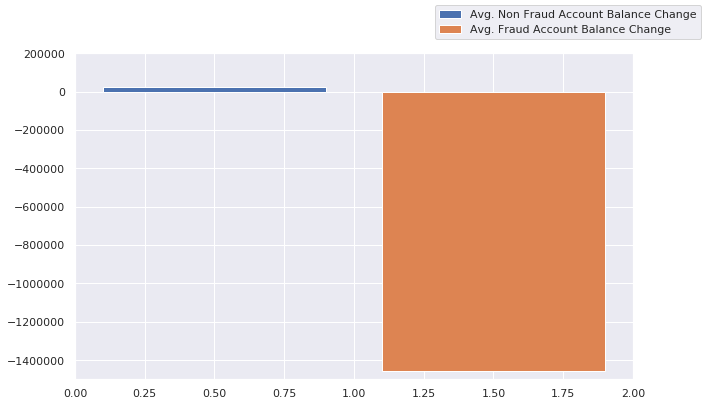

In [6]:
frauds = df[df.isFraud == 1]
non_frauds = df[df.isFraud == 0]

frauds['balanceChange'] = frauds['newbalanceOrig'] - frauds['oldbalanceOrg']
non_frauds['balanceChange'] = non_frauds['newbalanceOrig'] - non_frauds['oldbalanceOrg']

frauds_mean_balancechange = frauds['balanceChange'].mean()
nfrauds_mean_balancechange = non_frauds['balanceChange'].mean()

width = 0.8
fig, ax = plt.subplots(1,1, figsize = (10, 6))
ax.bar(0.5, nfrauds_mean_balancechange, width, label='Avg. Non Fraud Account Balance Change', align='center')
ax.bar(1.5, frauds_mean_balancechange, width, label='Avg. Fraud Account Balance Change')
fig.legend(loc='best')
plt.axis([0, 2, -1500000, 200000])

#### We can already see that fraudulent transactions have behavior that deviates greatly from the norm! Specifically, the average bank account balance change when fraud occurs is very large and negative

## This invites the question: How often does a fraudulent transaction lead to a positive account balance change?

In [7]:
num_positive_frauds = len(frauds[frauds['balanceChange'] > 0])
num_positive_frauds

0

### None of the fradulent transactions result in a positive account balance change! 

This makes sense if we consider that criminals would not be in the business of giving money away.

### Now, let's drop all the transactions that resulted in a positive account balance change, so that we are left with only transactions where we would expect fraud to happen 

In [8]:
paysim_negative = pd.concat([frauds[frauds['balanceChange'] <= 0], non_frauds[non_frauds['balanceChange'] <= 0]])

### We can figure out what percentage of these non-positive balance change transactions turn out to be fradulent

In [9]:
num_frauds = len(paysim_negative[paysim_negative['isFraud'] == 1])
num_frauds / len(paysim_negative)

0.0016547234971743979

### Frauds account for only 0.17% of suspected transactions! This reveals that our dataset is highly imbalanced between frauds and non-frauds

#### In fact, the data has so few frauds that a stupid classifier (i.e. always predicting not fraud) would get ~99.8% accuracy on our selected data! Because of this, accuracy will not be an important metric to consider while building our model


### Let's consider now what features are correlated with the fraudulent transactions we do have

In [10]:
paysim_negative.corr()

step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.025573      -0.016792       -0.032128   
amount          0.025573  1.000000       0.085917       -0.017641   
oldbalanceOrg  -0.016792  0.085917       1.000000        0.849394   
newbalanceOrig -0.032128 -0.017641       0.849394        1.000000   
oldbalanceDest  0.025366  0.343287      -0.026922       -0.040110   
newbalanceDest  0.024736  0.523497      -0.019567       -0.044628   
isFraud         0.035890  0.076894       0.281881        0.036366   
isFlaggedFraud  0.003719  0.012347       0.060569        0.079985   
balanceChange  -0.014197 -0.185488      -0.663233       -0.168364   

                oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  \
step                  0.025366        0.024736  0.035890        0.003719   
amount                0.343287        0.523497  0.076894        0.012347   
oldbalanceOrg        -0.026922       -0.019567  0.281881        0.060569   
newbalanceOrig       -0.040110       -0.044628  0.036366        0.079985   
oldbalanceDest        1.000000        0.972241 -0.005183       -0.000525   
newbalanceDest        0.972241        1.000000  0.001367       -0.000567   
isFraud              -0.005183        0.001367  1.000000        0.044101   
isFlaggedFraud       -0.000525       -0.000567  0.044101        1.000000   
balanceChange        -0.006596       -0.026741 -0.474914        0.000297   

                balanceChange  
step                -0.014197  
amount              -0.185488  
oldbalanceOrg       -0.663233  
newbalanceOrig      -0.168364  
oldbalanceDest      -0.006596  
newbalanceDest      -0.026741  
isFraud             -0.474914  
isFlaggedFraud       0.000297  
balanceChange        1.000000

#### We can group the most relevant features by the name of the client who receives the funds

In [11]:
paysim_byClient = paysim_negative[['nameDest', 'oldbalanceOrg', 'oldbalanceDest', 'balanceChange']].groupby(['nameDest']).mean()
frauds_byClient = paysim_negative[['nameDest', 'isFraud']].groupby(['nameDest']).sum()
clientData = pd.concat([paysim_byClient, frauds_byClient], axis=1)
clientData['numTrans'] = paysim_negative[['nameDest', 'isFraud']].groupby(['nameDest']).count()['isFraud']
clientData = clientData.sort_values(by='isFraud', ascending=False)
clientData.head(20)

oldbalanceOrg  oldbalanceDest  balanceChange  isFraud  numTrans
nameDest                                                                    
C1193568854   5.330978e+04    2.852079e+06  -3.098634e+04        2        28
C1837027614   4.755950e+05    0.000000e+00  -4.755950e+05        2         2
C2020337583   2.794975e+04    1.675035e+06  -2.794975e+04        2        27
C1827800010   5.702405e+05    0.000000e+00  -5.702405e+05        2         2
C1325541393   4.644843e+04    3.539555e+06  -4.644843e+04        2        19
C1653587362   1.548816e+05    1.426334e+05  -1.548816e+05        2         7
C1780714769   1.387490e+05    2.551755e+05  -1.387490e+05        2         6
C1399829166   2.644445e+05    3.084512e+06  -2.165542e+05        2        18
C410033330    3.562305e+04    5.997529e+06  -2.517144e+04        2        38
C644163395    8.904530e+04    4.245709e+06  -8.641368e+04        2        17
C1669818195   2.231886e+06    3.338856e+05  -2.212229e+06        2         4
C1655359478   4.282963e+04    3.473221e+06  -3.083249e+04        2        25
C1980653895   3.884991e+04    8.240083e+06  -1.395924e+04        2        25
C1259079602   2.213236e+05    7.878141e+05  -2.213236e+05        2         6
C105660024    7.002115e+04    1.035281e+06  -6.664730e+04        2        11
C1827219533   7.035224e+04    4.564777e+06  -7.035224e+04        2        22
C967226405    1.207240e+05    1.539773e+06  -1.207240e+05        2        12
C1013511446   1.961548e+05    8.234985e+06  -1.608287e+05        2        25
C904300960    6.986146e+04    2.314621e+06  -6.986146e+04        2        23
C1650668671   1.952796e+04    5.165436e+04  -1.829446e+04        2         4

### We can look further into each feature


#### First, we can plot number of frauds versus the original account balance of victims

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce0dd03ac8>]],
      dtype=object)

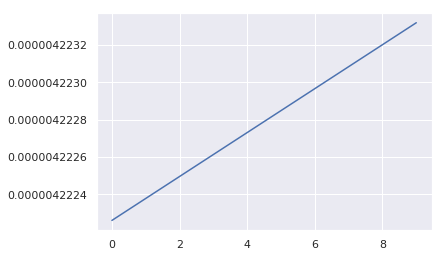

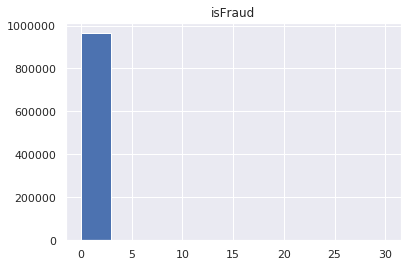

In [12]:
from scipy import stats

oldBalance = clientData[['oldbalanceOrg', 'isFraud']].groupby(['oldbalanceOrg']).sum()
kde = stats.gaussian_kde(oldBalance.index)
xx = np.linspace(0, 9, 1000)
plt.plot(xx, kde(xx))
oldBalance[1:].hist(bins=10)

#### We can do a similar thing with the resulting acccount balance of victims AFTER the fraud occurs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce0dcfaa20>]],
      dtype=object)

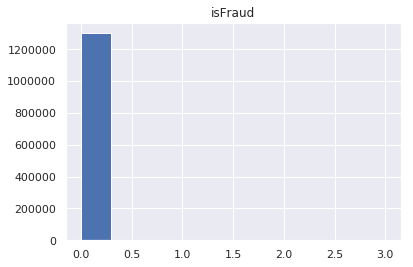

In [13]:
newBalanceOrig = paysim_negative[['newbalanceOrig', 'isFraud']].groupby(['newbalanceOrig']).sum()
newBalanceOrig[1:].hist(bins=10)

#### A plot of the account balance of the fraudsters BEFORE the fradulent transactions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce0dcd8ac8>]],
      dtype=object)

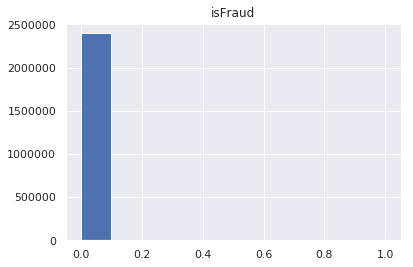

In [14]:
oldBalanceDest = paysim_negative[['oldbalanceDest', 'isFraud']].groupby(['oldbalanceDest']).sum()
oldBalanceDest[1:].hist(bins=10)

#### We can see that most people who commit fraud have less than a dollar in their account

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce0dc1bf28>]],
      dtype=object)

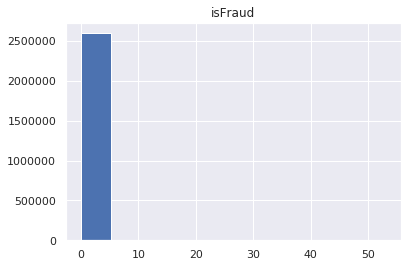

In [15]:
newBalanceDest = paysim_negative[['newbalanceDest', 'isFraud']].groupby(['newbalanceDest']).sum()
newBalanceDest[1:].hist(bins=10)

#### After fraud, account balances creep up by a few dollars


### So most fraudulent transactions leave victim's with only dollars in their accounts and go to recipients with low account balances

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce0db40780>]],
      dtype=object)

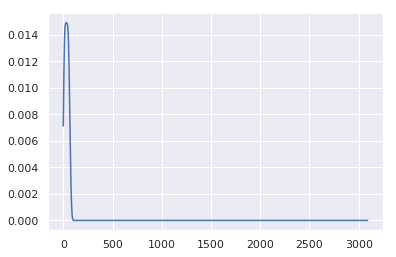

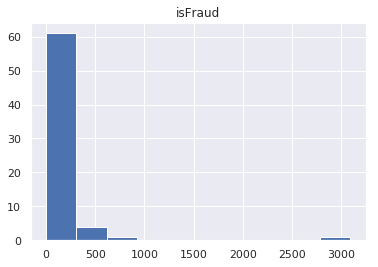

In [16]:
numTrans = clientData[['numTrans', 'isFraud']].groupby(['numTrans']).sum()
kde = stats.gaussian_kde(numTrans.index)
xx = np.linspace(0, max(numTrans.isFraud), 1000)
plt.plot(xx, kde(xx))
numTrans.hist(bins=10)

#### Also, fraud is more spread out versus the number of transactions feature, but with a majority of fraud committed by clients who perform a relatively small number of transactions.

We can also see how transactions are distributed across various payment types.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

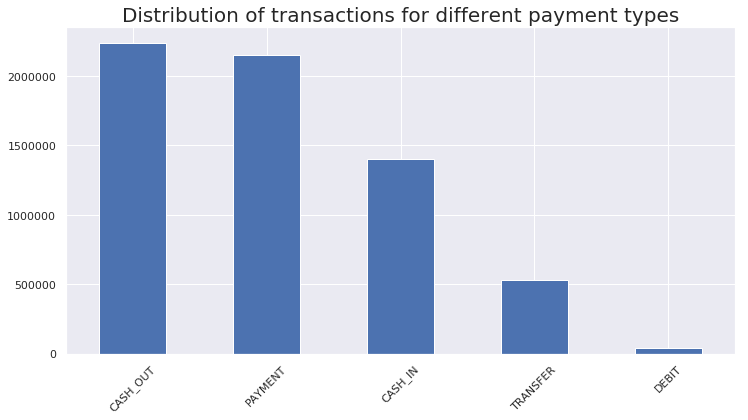

In [17]:
ax = df.type.value_counts().plot.bar(figsize = (12, 6))
ax.set_title("Distribution of transactions for different payment types", fontsize = 20)
plt.xticks(rotation = 45)

Now that we have a better understanding of our dataset, let's move onto preprocessing the data and creating predictive models.

### Data Preprocessing

Let's start off by dropping unnecessary features. 'step' refers to a timestep but there is no way of tying multiple transactions together to form a sequence of related payments. So it doesn't serve any purpose in our models. 'isFlaggedFraud' predominantly features zeroes with around 15 rows with a one. 'nameOrig' and 'nameDest' are identifiers which shouldn't be a part of models.

In [18]:
df.drop(columns = ['step', 'isFlaggedFraud', 'nameOrig', 'nameDest'], inplace = True)
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Let's split-up the features and the label.

In [19]:
X = df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].copy()
y = df['isFraud'].copy()
X.type = X.type.astype('category')

Now, let's encode the categorical variable 'type' using one-hot encoding. In order to prevent data leakage, we will be doing this transformation based on only the training dataset.

In [20]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

col_transform = make_column_transformer((['type'], OneHotEncoder(sparse = False, drop = 'first')),
                                        remainder = 'passthrough')
X = pd.DataFrame(col_transform.fit_transform(X))

/opt/conda/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:778: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


# Predictive Modelling

For a problem with highly imbalanced classes, there are three approaches one can take.
- **No sampling**: Train models as it is without disturbing the balance of the dataset
- **Undersampling**: Randomly select observations from the bigger class such that it ends up having the same number of observations as the smaller class.
- **Oversampling**: Systematically create new observations for the smaller class such that it ends up having the same number of observations as the bigger class.

For all these approaches, we are using Random Forests and XGBoost as they are known to perform well on imbalanced classes. Just for the undersampling case, we are also training an artifical neural network (as it is feasible and practical in this case). 

In order to evaluate the models, we are using 5-fold cross-validation with the evaluation metric being the area under the precision-recall curve.


## Type I - No sampling technique

### Random Forests

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

cv_pr_aucs = []
recalls = []
precisions = []
thresholds_list = []
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    print("Started training the model for the current fold at", datetime.now())
    rf_model = RandomForestClassifier(random_state = 42)
    rf_model.fit(X_train, y_train)
    y_pred = list(rf_model.predict_proba(X_test)[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test.tolist(), y_pred)
    recalls.append(recall)
    precisions.append(precision)
    thresholds_list.append(thresholds)
    cv_pr_aucs.append(auc(recall, precision))
    print("Completed training the model for the current fold at", datetime.now(), "\n")

Started training the model for the current fold at 2019-09-28 02:02:07.746424
Completed training the model for the current fold at 2019-09-28 02:05:40.131237 

Started training the model for the current fold at 2019-09-28 02:05:40.759415
Completed training the model for the current fold at 2019-09-28 02:09:01.322461 

Started training the model for the current fold at 2019-09-28 02:09:01.942238
Completed training the model for the current fold at 2019-09-28 02:12:39.001234 

Started training the model for the current fold at 2019-09-28 02:12:39.603898
Completed training the model for the current fold at 2019-09-28 02:16:28.201304 

Started training the model for the current fold at 2019-09-28 02:16:28.798428
Completed training the model for the current fold at 2019-09-28 02:20:01.620963 



Let's plot the feature importances since this happens to be the best model we've obtained.

Text(0, 0.5, 'Importance (%)')

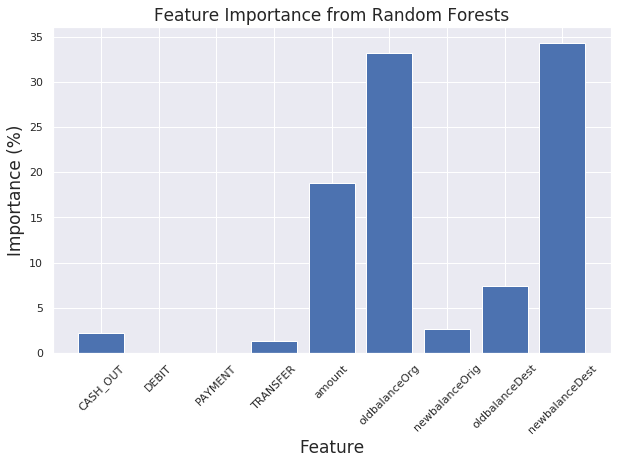

In [22]:
rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X, y)

fig, axis = plt.subplots(figsize = (10, 6))
feature_list = ['CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
axis.bar(feature_list, (rf_model.feature_importances_ * 100))
plt.xticks(rotation = 45)
axis.set_title('Feature Importance from Random Forests', fontsize = 17)
axis.set_xlabel('Feature', fontsize = 17)
axis.set_ylabel('Importance (%)', fontsize = 17)

It's quite intuitive that the old and new balances seem to be the most important features looking at the EDA above.

Now, let's plot the precision-recall curve and calculate the area under it.

Area under PR curve: 0.9255479191398454


Text(0, 0.5, 'Precision')

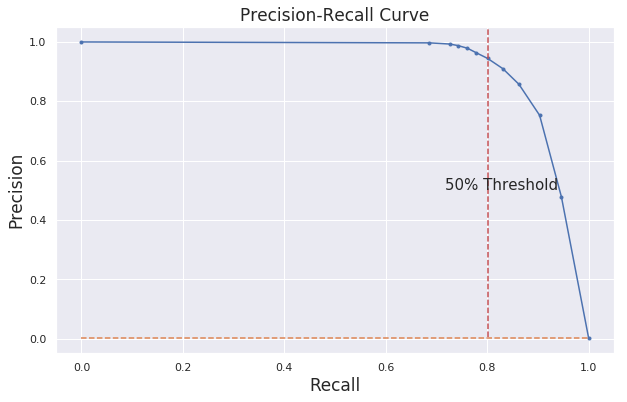

In [23]:
print("Area under PR curve:", np.mean(cv_pr_aucs))

precision = np.mean(precisions, axis = 0)
recall = np.mean(recalls, axis = 0)
threshold = np.mean(thresholds_list, axis = 0)

fig = plt.figure(figsize = (10, 6))
plt.plot(recall, precision, marker = '.')
plt.plot([0, 1], [sum(y == 1)/len(y), sum(y == 1)/len(y)], linestyle = '--')
ax = plt.gca()
ax.axvline(x = recall[int(np.where(threshold == 0.5)[0])], color = 'r', linestyle = '--', ymin = 0.05, ymax = 1)
ax.annotate('50% Threshold', (recall[int(np.where(threshold == 0.5)[0])] - 0.085, recall[int(np.where(threshold == 0.5)[0])] - 0.3), fontsize = 15)
ax.set_title("Precision-Recall Curve", fontsize = 17)
ax.set_xlabel('Recall', fontsize = 17)
ax.set_ylabel('Precision', fontsize = 17)

### XGBoost

In [24]:
from xgboost import XGBClassifier

cv_pr_aucs = []
recalls = []
precisions = []
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    print("Started training the model for the current fold at", datetime.now())
    xgb_model = XGBClassifier(random_state = 42)
    xgb_model.fit(X_train, y_train)
    y_pred = list(xgb_model.predict_proba(X_test)[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test.tolist(), y_pred)
    recalls.append(recall)
    precisions.append(precision)
    cv_pr_aucs.append(auc(recall, precision))
    print("Completed training the model for the current fold at", datetime.now(), "\n")
    
print("Area under PR curve:", np.mean(cv_pr_aucs))

Started training the model for the current fold at 2019-09-28 02:24:49.340993
[02:24:50] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Completed training the model for the current fold at 2019-09-28 02:47:09.852289 

Started training the model for the current fold at 2019-09-28 02:47:10.889339
[02:47:12] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Completed training the model for the current fold at 2019-09-28 03:09:10.570829 

Started training the model for the current fold at 2019-09-28 03:09:12.241061
[03:09:13] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on singl

Given that XGBoost leads to a different set of thresholds for every fold of the cross-validation, we are unable to plot the curve.

## Type II - Undersampling

### Random Forests

In this case, since it's practically feasible given the relatively smaller dataset owing to undersampling, we would be using GridSearchCV to try out different hyperparameter combinations.

In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [10, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 3, 5]
             }

In [26]:
from sklearn.utils import resample

cv_pr_aucs = []
recalls = []
precisions = []
thresholds_list = []
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]    
    
    X_frauds_df = X_train[y_train == 1]
    y_frauds_df = y_train[y_train == 1]
    
    X_not_frauds_df = X_train[y_train == 0]
    y_not_frauds_df = y_train[y_train == 0]
    
    X_not_frauds_df, y_not_frauds_df = resample(X_not_frauds_df, y_not_frauds_df, replace = False, n_samples = len(X_frauds_df), random_state = 42)
    
    X_train = pd.concat([X_frauds_df, X_not_frauds_df])
    y_train = pd.concat([y_frauds_df, y_not_frauds_df])
    
    X_train = X_train.reset_index().drop(columns = ['index'])
    y_train = y_train.reset_index().drop(columns = ['index'])
    
    print("Started training the model for the current fold at", datetime.now())
    rf_model = RandomForestClassifier(random_state = 42)
    rf_model = GridSearchCV(rf_model, parameters, cv = 5, scoring = 'average_precision')
    rf_model.fit(X_train, y_train)
    y_pred = list(rf_model.predict_proba(X_test)[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test.tolist(), y_pred)
    recalls.append(recall)
    precisions.append(precision)
    thresholds_list.append(thresholds)
    cv_pr_aucs.append(auc(recall, precision))
    print("Completed training the model for the current fold at", datetime.now(), "\n")

Started training the model for the current fold at 2019-09-28 04:15:33.812478
Completed training the model for the current fold at 2019-09-28 04:16:28.741021 

Started training the model for the current fold at 2019-09-28 04:16:30.171710
Completed training the model for the current fold at 2019-09-28 04:17:23.707541 

Started training the model for the current fold at 2019-09-28 04:17:25.153187
Completed training the model for the current fold at 2019-09-28 04:18:20.106271 

Started training the model for the current fold at 2019-09-28 04:18:21.420983
Completed training the model for the current fold at 2019-09-28 04:19:17.043663 

Started training the model for the current fold at 2019-09-28 04:19:18.354679
Completed training the model for the current fold at 2019-09-28 04:20:14.829553 



In [27]:
print("Area under PR curve:", np.mean(cv_pr_aucs))

Area under PR curve: 0.815882679742073


### XGBoost

In [28]:
parameters = {'n_estimators': [10, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 6]
             }

In [29]:
cv_pr_aucs = []
recalls = []
precisions = []
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]    
    
    X_frauds_df = X_train[y_train == 1]
    y_frauds_df = y_train[y_train == 1]
    
    X_not_frauds_df = X_train[y_train == 0]
    y_not_frauds_df = y_train[y_train == 0]
    
    X_not_frauds_df, y_not_frauds_df = resample(X_not_frauds_df, y_not_frauds_df, replace = False, n_samples = len(X_frauds_df), random_state = 42)
    
    X_train = pd.concat([X_frauds_df, X_not_frauds_df])
    y_train = pd.concat([y_frauds_df, y_not_frauds_df])
    
    X_train = X_train.reset_index().drop(columns = ['index'])
    y_train = y_train.reset_index().drop(columns = ['index'])
    
    print("Started training the model for the current fold at", datetime.now())
    xgb_model = XGBClassifier(random_state = 42)
    xgb_model = GridSearchCV(xgb_model, parameters, cv = 5, scoring = 'average_precision')
    xgb_model.fit(X_train, y_train)
    y_pred = list(xgb_model.predict_proba(X_test)[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test.tolist(), y_pred)
    recalls.append(recall)
    precisions.append(precision)
    cv_pr_aucs.append(auc(recall, precision))
    print("Completed training the model for the current fold at", datetime.now(), "\n")

Started training the model for the current fold at 2019-09-28 04:20:18.366434
Completed training the model for the current fold at 2019-09-28 04:21:04.398190 

Started training the model for the current fold at 2019-09-28 04:21:05.723646
Completed training the model for the current fold at 2019-09-28 04:21:51.401696 

Started training the model for the current fold at 2019-09-28 04:21:52.631481
Completed training the model for the current fold at 2019-09-28 04:22:38.422548 

Started training the model for the current fold at 2019-09-28 04:22:39.723571
Completed training the model for the current fold at 2019-09-28 04:23:26.521130 

Started training the model for the current fold at 2019-09-28 04:23:27.781201
Completed training the model for the current fold at 2019-09-28 04:24:14.186821 



In [30]:
print("Area under PR curve:", np.mean(cv_pr_aucs))

Area under PR curve: 0.8596264435863746


### Neural Network

We are running a neural network only for the undersampling case as the training time for the other two cases (oversampling and no sampling) are extremely high (more than 8 hours) and the results are far worse than some of the other less complex models.

Also, we are not using cross-validation to evaluate the model as it's extremely time-consuming. Instead, we are using the train-test set approach.

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


The network we are creating consists of an input layer with 9 nodes, the first hidden layer with 12 nodes and RELU activation functions, the second hidden layer with 8 nodes and RELU activation functions and finally, the output node with a sigmoid activation function to get the prediction probability.

We are also standardizing the features as it improves the performance and accuracy of neural networks.

In [32]:
model = Sequential()
model.add(Dense(12, input_dim = 9, activation = 'relu'))
model.add(Dropout(0.3, seed = 42))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 42)

X_frauds_df = X_train[y_train == 1]
y_frauds_df = y_train[y_train == 1]

X_not_frauds_df = X_train[y_train == 0]
y_not_frauds_df = y_train[y_train == 0]

X_not_frauds_df, y_not_frauds_df = resample(X_not_frauds_df, y_not_frauds_df, replace = False, n_samples = len(X_frauds_df), random_state = 42)

X_train = pd.concat([X_frauds_df, X_not_frauds_df])
y_train = pd.concat([y_frauds_df, y_not_frauds_df])

X_train = X_train.reset_index().drop(columns = ['index'])
y_train = y_train.reset_index().drop(columns = ['index'])

std_scaler = StandardScaler()
X_train = pd.DataFrame(std_scaler.fit_transform(X_train))

In [34]:
model.fit(X_train, y_train, epochs = 150, batch_size = 10)

Epoch 1/150
13962/13962 [==============================] - 2s 168us/step - loss: 0.4314 - accuracy: 0.7890
Epoch 2/150
13962/13962 [==============================] - 2s 151us/step - loss: 0.3196 - accuracy: 0.8399
Epoch 3/150
13962/13962 [==============================] - 2s 151us/step - loss: 0.2945 - accuracy: 0.8529
Epoch 4/150
13962/13962 [==============================] - 2s 150us/step - loss: 0.2753 - accuracy: 0.8662
Epoch 5/150
13962/13962 [==============================] - 2s 148us/step - loss: 0.2580 - accuracy: 0.8762
Epoch 6/150
13962/13962 [==============================] - 2s 153us/step - loss: 0.2513 - accuracy: 0.8795
Epoch 7/150
13962/13962 [==============================] - 2s 155us/step - loss: 0.2367 - accuracy: 0.8881
Epoch 8/150
13962/13962 [==============================] - 2s 151us/step - loss: 0.2256 - accuracy: 0.8954
Epoch 9/150
13962/13962 [==============================] - 2s 158us/step - loss: 0.2113 - accuracy: 0.9050
Epoch 10/150
13962/13962 [===========

In [35]:
losses = model.history.history['loss']
accs = model.history.history['acc']

KeyError: 'acc'

Text(0, 0.5, 'Loss')

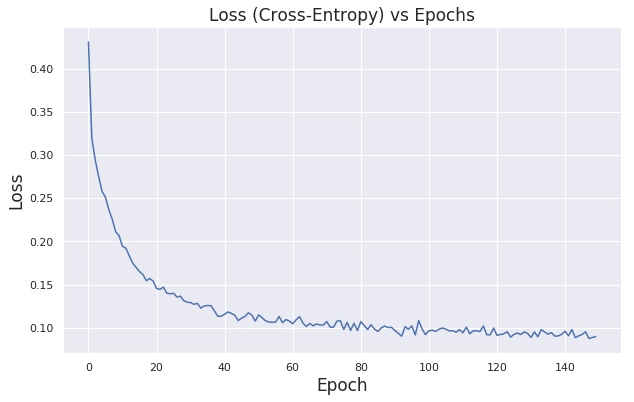

In [36]:
fig = plt.figure(figsize = (10, 6))
plt.plot(losses)
ax = plt.gca()
ax.set_title("Loss (Cross-Entropy) vs Epochs", fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 17)
ax.set_ylabel('Loss', fontsize = 17)

In [37]:
fig = plt.figure(figsize = (10, 6))
plt.plot(np.array(accs)*100)
ax = plt.gca()
ax.set_title("Accuracy vs Epochs", fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 17)
ax.set_ylabel('Accuracy (%)', fontsize = 17)

NameError: name 'accs' is not defined

<Figure size 720x432 with 0 Axes>

In [38]:
y_pred = model.predict_proba(std_scaler.transform(X_test))[:, 0]
precision, recall, thresholds = precision_recall_curve(y_test.tolist(), y_pred)
print("Area under PR curve: ", auc(recall, precision))

Area under PR curve:  0.8115898146617677


Text(0, 0.5, 'Precision')

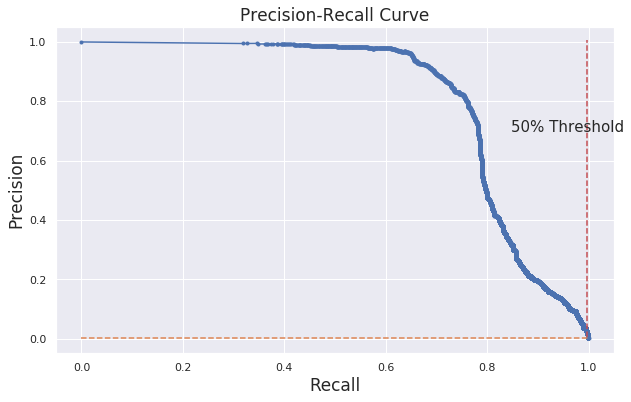

In [39]:
fig = plt.figure(figsize = (10, 6))
plt.plot(recall, precision, marker = '.')
plt.plot([0, 1], [sum(y == 1)/len(y), sum(y == 1)/len(y)], linestyle = '--')
ax = plt.gca()
ax.axvline(x = recall[int(np.where((thresholds > 0.49) & (thresholds < 0.51))[0][0])], color = 'r', linestyle = '--', ymin = 0.05, ymax = 0.96)
ax.annotate('50% Threshold', (recall[int(np.where((thresholds > 0.49) & (thresholds < 0.51))[0][0])] - 0.15, recall[int(np.where((thresholds > 0.49) & (thresholds < 0.51))[0][0])] - 0.3), fontsize = 15)
ax.set_title("Precision-Recall Curve", fontsize = 17)
ax.set_xlabel('Recall', fontsize = 17)
ax.set_ylabel('Precision', fontsize = 17)

## Type III - Oversampling

### Random Forests

In [40]:
from imblearn.over_sampling import SMOTE
from datetime import datetime

cv_pr_aucs = []
recalls = []
precisions = []
thresholds_list = []
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]   
    smote = SMOTE(random_state = 42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(X_train)
    y_train = pd.Series(y_train)
    
    print("Started training the model for the current fold at", datetime.now())
    rf_model = RandomForestClassifier(random_state = 42)
    rf_model.fit(X_train, y_train)
    y_pred = list(rf_model.predict_proba(X_test)[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test.tolist(), y_pred)
    recalls.append(recall)
    precisions.append(precision)
    thresholds_list.append(thresholds)
    cv_pr_aucs.append(auc(recall, precision))
    print("Completed training the model for the current fold at", datetime.now(), "\n")

Started training the model for the current fold at 2019-09-28 04:30:45.922247
Completed training the model for the current fold at 2019-09-28 04:40:54.728347 

Started training the model for the current fold at 2019-09-28 04:41:26.783229
Completed training the model for the current fold at 2019-09-28 04:51:06.752598 

Started training the model for the current fold at 2019-09-28 04:51:38.556543
Completed training the model for the current fold at 2019-09-28 05:01:22.378963 

Started training the model for the current fold at 2019-09-28 05:01:54.038039
Completed training the model for the current fold at 2019-09-28 05:12:01.175785 

Started training the model for the current fold at 2019-09-28 05:12:32.134244
Completed training the model for the current fold at 2019-09-28 05:22:31.638613 



Area under PR curve: 0.9174825411910985


Text(0, 0.5, 'Precision')

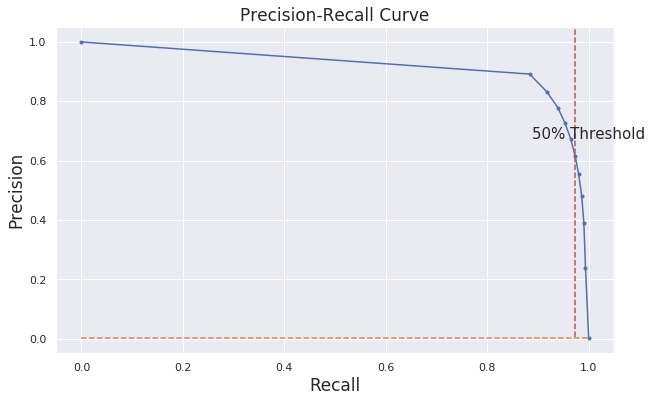

In [41]:
print("Area under PR curve:", np.mean(cv_pr_aucs))

precision = np.mean(precisions, axis = 0)
recall = np.mean(recalls, axis = 0)
threshold = np.mean(thresholds_list, axis = 0)

fig = plt.figure(figsize = (10, 6))
plt.plot(recall, precision, marker = '.')
plt.plot([0, 1], [sum(y == 1)/len(y), sum(y == 1)/len(y)], linestyle = '--')
ax = plt.gca()
ax.axvline(x = recall[int(np.where(threshold == 0.5)[0])], color = 'r', linestyle = '--', ymin = 0.05, ymax = 1)
ax.annotate('50% Threshold', (recall[int(np.where(threshold == 0.5)[0])] - 0.085, recall[int(np.where(threshold == 0.5)[0])] - 0.3), fontsize = 15)
ax.set_title("Precision-Recall Curve", fontsize = 17)
ax.set_xlabel('Recall', fontsize = 17)
ax.set_ylabel('Precision', fontsize = 17)

### XGBoost

In [42]:
cv_pr_aucs = []
recalls = []
precisions = []
thresholds_list = []
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]   
    smote = SMOTE(random_state = 42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(X_train)
    y_train = pd.Series(y_train)
    
    print("Started training the model for the current fold at", datetime.now())
    xgb_model = XGBClassifier(random_state = 42)
    xgb_model.fit(X_train, y_train)
    y_pred = list(xgb_model.predict_proba(X_test)[:, 1])
    precision, recall, thresholds = precision_recall_curve(y_test.tolist(), y_pred)
    recalls.append(recall)
    precisions.append(precision)
    thresholds_list.append(thresholds)
    cv_pr_aucs.append(auc(recall, precision))
    print("Completed training the model for the current fold at", datetime.now(), "\n")

Started training the model for the current fold at 2019-09-28 05:23:07.210512
[05:23:10] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Completed training the model for the current fold at 2019-09-28 06:08:40.447596 

Started training the model for the current fold at 2019-09-28 06:09:13.141711
[06:09:15] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Completed training the model for the current fold at 2019-09-28 06:55:54.166058 

Started training the model for the current fold at 2019-09-28 06:56:27.370457
[06:56:30] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on singl

In [43]:
print("Area under PR curve:", np.mean(cv_pr_aucs))

Area under PR curve: 0.8516222314077524


## Conclusion

Thus, we have analyzed the dataset and obtained a fairly accurate predictive model using Random Forests without any sampling, closely followed by Random Forests with oversampling. In order to reduce our chances of performing a Type II error (predicting a transaction as NOT FRAUD when it actually is one), we can move our threshold to less that 50% to increase Recall at the expense of Precision. This needs to be studied on a case-by-case basis.